In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [2]:
data = np.load("processed_data.npz")

In [3]:
# used for gym environment
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_test'])

In [4]:
data.files

['x_train', 'y_train', 'x_test', 'y_test']

In [5]:
data['x_train'].shape

(153582, 47)

In [6]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [7]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [8]:
train_matrix.shape

(153582, 10, 47)

In [9]:
test_matrix = get_padded_matrix( data['x_test'],  data['y_test'])

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_matrix.shape[2]-1)
])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                19600     
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 32,062
Trainable params: 32,062
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed{}".format(time()))
cp_callback = tf.keras.callbacks.ModelCheckpoint("sepsis_states.model",
                                                 verbose=1, monitor='val_loss', save_best_only=True)

early_stop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_matrix, data['y_train'], validation_data=(test_matrix, data['y_test']), epochs=10, callbacks=[tensorboard, cp_callback, early_stop])

Train on 153582 samples, validate on 39232 samples
Epoch 1/10
153582/153582 [==============================] - 76s 497us/step - loss: 0.1777 - val_loss: 0.1219

Epoch 00001: val_loss improved from inf to 0.12185, saving model to sepsis_states.model
Epoch 2/10
153582/153582 [==============================] - 64s 417us/step - loss: 0.1396 - val_loss: 0.1205

Epoch 00002: val_loss improved from 0.12185 to 0.12054, saving model to sepsis_states.model
Epoch 3/10
153582/153582 [==============================] - 62s 402us/step - loss: 0.1374 - val_loss: 0.1177

Epoch 00003: val_loss improved from 0.12054 to 0.11773, saving model to sepsis_states.model
Epoch 4/10
153582/153582 [==============================] - 60s 392us/step - loss: 0.1360 - val_loss: 0.1168

Epoch 00004: val_loss improved from 0.11773 to 0.11683, saving model to sepsis_states.model
Epoch 5/10
153582/153582 [==============================] - 60s 392us/step - loss: 0.1354 - val_loss: 0.1172

Epoch 00005: val_loss did not impro

In [14]:
model = tf.keras.models.load_model("sepsis_states.model")

In [15]:
test_predicted = model.predict(test_matrix)

In [16]:
train_predicted = model.predict(train_matrix)

In [17]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [18]:
test_predicted[0:11,columns.index('HeartRate')]

array([-0.66509765, -0.5026551 , -0.45024917, -0.44570047, -0.43237913,
       -0.4554737 , -0.9626406 , -0.88149446, -0.97048485, -0.88723314,
       -0.9479522 ], dtype=float32)

In [19]:
sns.set(style="white")

def plot(column, mode="test", prediction=test_predicted):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][6:24,columns.index(column)], label="truth", scaley=False)
    plt.plot(prediction[6:24,columns.index(column)], label="predicted", scaley=False)
    plt.ylim(-2, 2)
    plt.legend(["Real Value", "Predicted Value"])
    plt.title(column + " " + mode)
    plt.show()

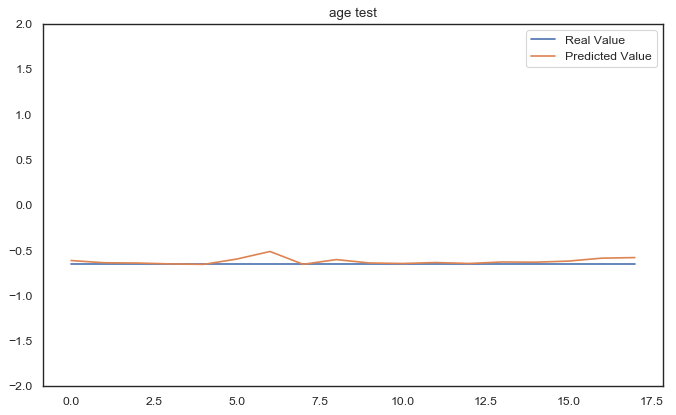

In [20]:
plot("age", "test", test_predicted)

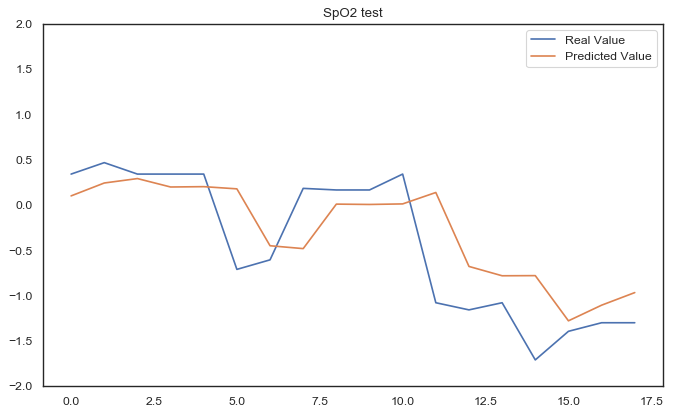

In [21]:
plot("SpO2", "test", test_predicted)

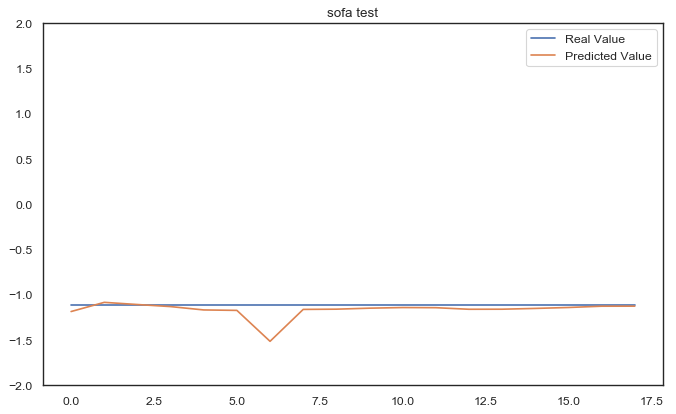

In [22]:
plot("sofa")

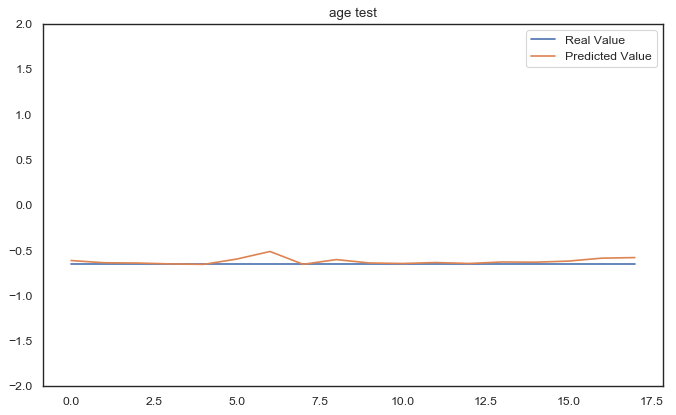

In [23]:
plot("age")

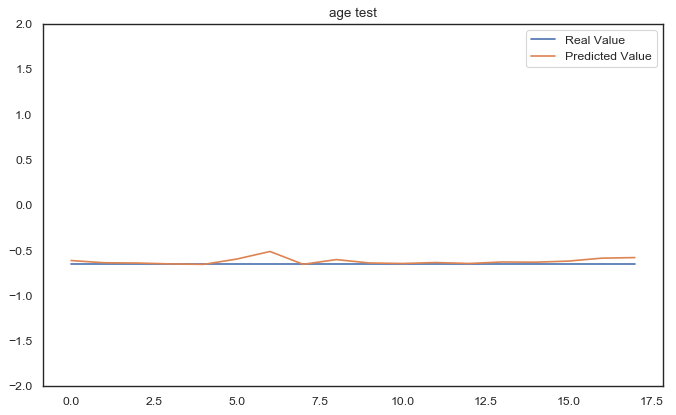

In [24]:
plot("age")

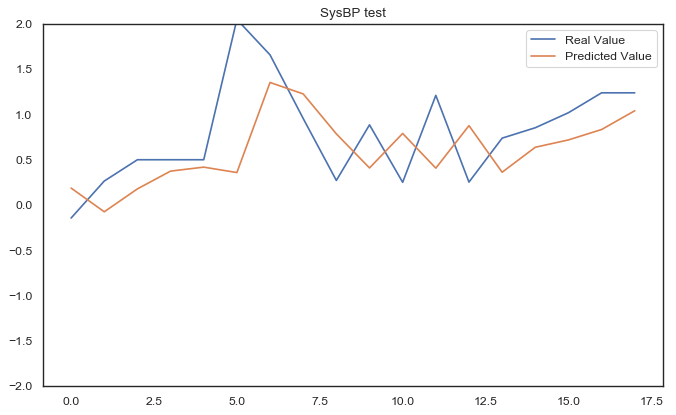

In [25]:
plot("SysBP")

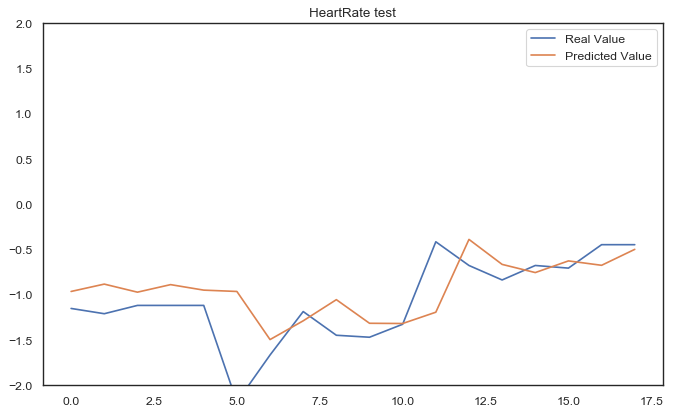

In [26]:
plot("HeartRate")

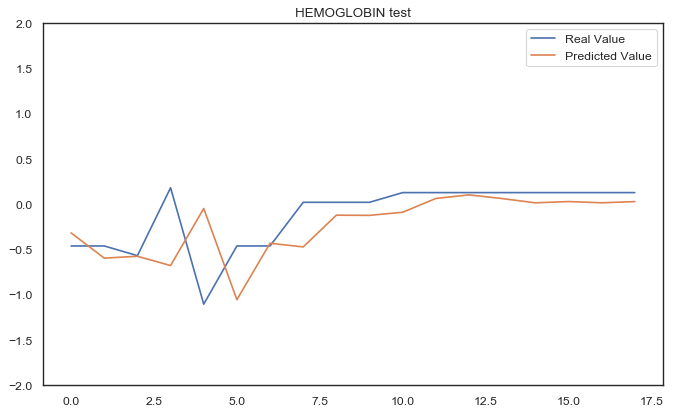

In [27]:
plot("HEMOGLOBIN")

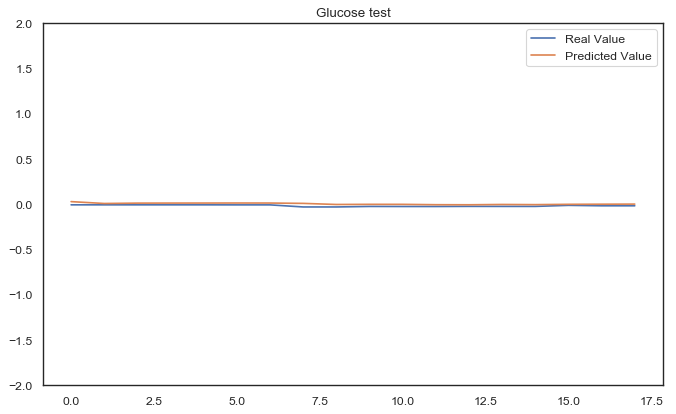

In [28]:
plot("Glucose")